In [1]:
%%capture

from data.process import combined

import pandas
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import scipy.stats

df = combined()

# Report on Community Engagement

Municipal Broadband PDX, an advocacy campaign supporting digital equity in the Portland metropolitan area, is pleased to have the opportunity to research and report on local residents' engagement with the proposed publicly-owned network in Multnomah County.

(TODO: Finish this introduction.)

## Survey Findings


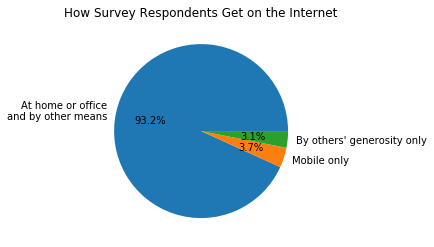

In [2]:
import textwrap

df.filter(['has_internet_premise', 'has_internet_mobile_only', 'has_internet_ext_only']).agg('sum').rename({
    'has_internet_premise': textwrap.fill('At home or office and by other means', 20),
    'has_internet_mobile_only': 'Mobile only',
    'has_internet_ext_only': "By others' generosity only",
}).plot(kind='pie', autopct='%.1f%%', title='How Survey Respondents Get on the Internet')
plt.ylabel(None)

plt.show()

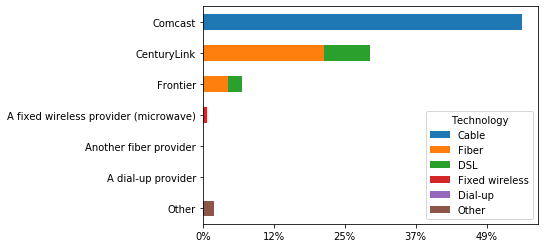

In [3]:
techs_by_provider = df.pivot_table(index='isp', columns='isp_tech', aggfunc='size')

ax = techs_by_provider.plot(kind='barh', stacked=True)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0, xmax=df.has_internet_premise.count()))
ax.legend(fancybox=True, title='Technology')
ax.set_ylabel(None)
ax.invert_yaxis()

plt.show()

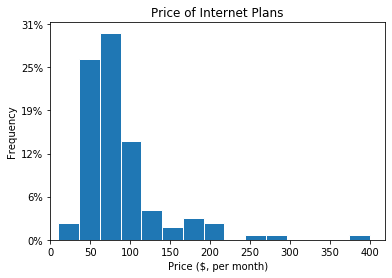

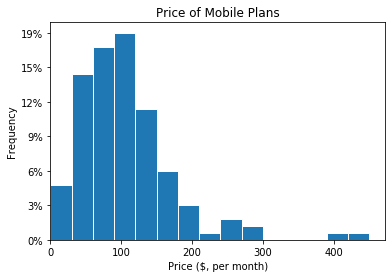

In [4]:
for col, label in {'internet_price': 'Internet', 'mobile_price': 'Mobile'}.items():
    plt.title('Price of {0} Plans'.format(label))
    plt.xlabel('Price ($, per month)')
    plt.ylabel('Count')
    plt.grid(True)

    ax = df[col].plot(kind='hist', bins=15, edgecolor='w')
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0, xmax=len(df.index)))

    plt.xlim(left=0)
    plt.show()

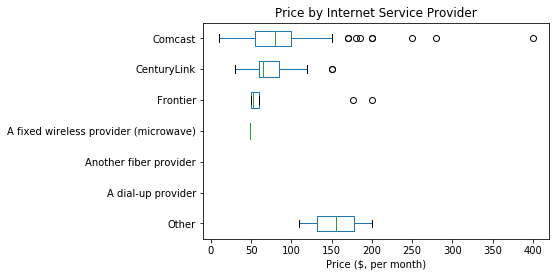

In [5]:
ax = df.boxplot(by='isp', column='internet_price', vert=False, grid=False)
ax.invert_yaxis()

plt.title('Price by Internet Service Provider')
plt.suptitle(None)
plt.xlabel('Price ($, per month)')

plt.show()

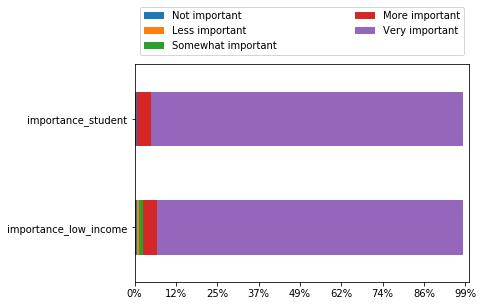

In [6]:
s = df.filter(['importance_student', 'importance_low_income']).stack()
idf = pandas.DataFrame(s.groupby([pandas.Grouper(level=1), s]).size()).unstack()
idf.columns = idf.columns.droplevel()

ax = idf.plot(kind='barh', stacked=True)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0, xmax=len(df.index)))

plt.xlim(0, len(df.index))
plt.legend(loc='lower left', mode='expand', bbox_to_anchor=(0, 1.02, 1, 0.2), ncol=2)

plt.show()

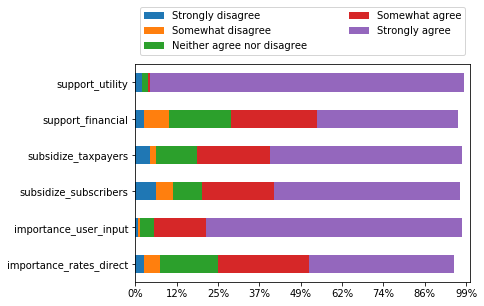

In [7]:
s = df.filter([
    'support_utility',
    'support_financial',
    'importance_user_input',
    'importance_rates_direct',
    'subsidize_subscribers',
    'subsidize_taxpayers',
]).stack()
idf = pandas.DataFrame(s.groupby([pandas.Grouper(level=1), s]).size()).unstack()
idf.columns = idf.columns.droplevel()

ax = idf.plot(kind='barh', stacked=True)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0, xmax=len(df.index)))

plt.xlim(0, len(df.index))
plt.legend(loc='lower left', mode='expand', bbox_to_anchor=(0, 1.02, 1, 0.2), ncol=2)

plt.show()